In [1]:
import numpy as np
import pybullet as p
import pandas as pd
import time
from robot_descriptions.loaders.pybullet import load_robot_description

pybullet build time: Nov 29 2024 16:26:49


In [2]:
p.connect(p.GUI_SERVER)
p.setTimeStep(0.0001)
p.setGravity(0, 0, -9.81)

Version = 4.1 Metal - 76.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

MotionThreadFunc thread started


In [3]:
robot_id = load_robot_description('ur5_description', useFixedBase=True) 
joint_indices = [i for i in range(p.getNumJoints(robot_id)) if p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE]
for i in range(p.getNumJoints(robot_id)):
  print(p.getJointInfo(robot_id, i))
  print(p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE)

immovable_joints = [6, 8]
wrist3_joint = 6
eff_idx = 7
pendulum_joint_idx = 8
print("End effector joint: ", eff_idx)
print("Revolute joints: ", joint_indices)

(0, b'world_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'base_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
False
(1, b'shoulder_pan_joint', 0, 7, 6, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'shoulder_link', (0.0, 0.0, 1.0), (0.0, 0.0, 0.089159), (0.0, 0.0, 0.0, 1.0), 0)
True
(2, b'shoulder_lift_joint', 0, 8, 7, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'upper_arm_link', (0.0, 1.0, 0.0), (0.0, 0.13585, 0.0), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 1)
True
(3, b'elbow_joint', 0, 9, 8, 1, 0.0, 0.0, -3.14159265359, 3.14159265359, 150.0, 3.15, b'forearm_link', (0.0, 1.0, 0.0), (0.0, -0.1197, 0.14499999999999996), (0.0, 0.0, 0.0, 1.0), 2)
True
(4, b'wrist_1_joint', 0, 10, 9, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_1_link', (0.0, 1.0, 0.0), (0.0, 0.0, 0.14225), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 3)
True
(5, b'wrist_2_joint', 0, 11, 10, 1, 0.0, 0.0, -0.223598776, 0.223598776, 

# Inverse kinematics with preferred positions

In [4]:
#lower limits for null space
ll = [3.14 / 18 * x for x in [-36, 3.5, -6.5, 1.5, -4, 17.5, 0]]
#upper limits for null space
ul = [3.14 / 18 * x for x in [36,  4.5, -5.5, 4.5,  4, 17.5, 0]]
#joint ranges for null space
jr = [3.14 / 18  * x for x in [72,    1,    1,   3,  8,    0, 0]]
#restposes for null space
rp = [3.14 / 18 * x for x in [0,     4,   -6,   3,  0, 17.5, 0]]

print(ll)
print(ul)
print(jr)
print(rp)

def smoothInverseKinematics(robot_id, eff_idx, target_pos):
  current_positon = p.getLinkState(robot_id, eff_idx)[0]
  return p.calculateInverseKinematics(
    robot_id,
    eff_idx,
    target_pos,
    lowerLimits = ll,
    upperLimits = ul,
    jointRanges = jr,
    restPoses   = rp,
    solver=420,
    maxNumIterations=20,
    residualThreshold=.01
  )

[-6.28, 0.6105555555555556, -1.133888888888889, 0.2616666666666667, -0.6977777777777778, 3.052777777777778, 0.0]
[6.28, 0.785, -0.9594444444444445, 0.785, 0.6977777777777778, 3.052777777777778, 0.0]
[12.56, 0.17444444444444446, 0.17444444444444446, 0.5233333333333334, 1.3955555555555557, 0.0, 0.0]
[0.0, 0.6977777777777778, -1.0466666666666669, 0.5233333333333334, 0.0, 3.052777777777778, 0.0]


# Disable default motor control

In [5]:
for i in joint_indices:
    p.setJointMotorControl2(
        bodyUniqueId=robot_id,
        jointIndex=i,
        controlMode=p.VELOCITY_CONTROL,
        force=0  # Disable motor forces
    )

# Feedback and Stabilization

In [6]:
def pd_control(robot_id, q_desired, v_desired, Kp, Kd):
  joint_states = p.getJointStates(robot_id, joint_indices)
  q_measured = np.array([state[0] for state in joint_states])
  v_measured = np.array([state[1] for state in joint_states])
  position_error = q_desired - q_measured
  velocity_error = v_desired - v_measured
  
  tau = Kp * position_error + Kd * velocity_error
  # add gravity compensation
  tau += np.array(p.calculateInverseDynamics(robot_id, q_measured.tolist(), [0] * len(joint_indices), [0] * len(joint_indices)))
  for i in range(len(joint_indices)):
    if joint_indices[i] in immovable_joints: # ensure pendulum and wrist 3 joint is commanded with zero torque
      tau[i] = 0
  return tau

Kp = 100 * np.ones_like(joint_indices)
Kd = 5 * np.ones_like(joint_indices)

def control_to_desired_configuration(robot_id, q_desired, v_desired=None, max_steps=5000, sleep=None):
  if v_desired is None:
    v_desired = np.zeros_like(q_desired)
  for step in range(max_steps):  # Simulation steps
    torques = pd_control(robot_id, q_desired, v_desired, Kp, Kd).tolist()
    p.setJointMotorControlArray(
      bodyUniqueId=robot_id,
      jointIndices=joint_indices,
      controlMode=p.TORQUE_CONTROL,
      forces=torques
    )
    p.stepSimulation()
    if sleep is not None:
      time.sleep(sleep)
    

# Resetting to balanced pose

In [7]:
rest_pose_balancing = [np.pi / 18 * x for x in [0, 4, -6, 3, 0, 17.3, 0]]
def reset_to_balancing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=-rest_pose_balancing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
      )

In [8]:
reset_to_balancing_pose(robot_id)
for _ in range(1000):
  p.stepSimulation()
  time.sleep(1 / 240.0)

In [34]:
rest_pose_swing = [np.pi / 18 * x for x in [0, 4, -6, 3, 0, -0.7, 18]]
def reset_to_swing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=-rest_pose_swing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
          )

In [39]:
reset_to_swing_pose(robot_id)
for _ in range(100):
  p.stepSimulation()
  time.sleep(1 / 240.0)

In [9]:
print(p.getLinkState(robot_id, eff_idx))

((-0.14817353738091515, 0.5253125444382822, 0.24820681800360578), (0.9431227580589041, 0.2995063042063883, -0.023132242095106205, 0.14240904587718267), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), (-0.14817354083061218, 0.5253125429153442, 0.24820682406425476), (0.9431227445602417, 0.2995063066482544, -0.023132242262363434, 0.1424090415239334))


In [10]:
p.calculateInverseKinematics(robot_id, eff_idx, (0.7105991188452455, 0.19145000000000006, 0.13497427907824033))

(-2.592828433681426,
 -3.6366718337288426,
 0.9528549038234174,
 0.32206969024520976,
 -0.029645342794459312,
 -4.724387428565335,
 -0.8073026164801754)

# Moving end-effector along a horizontal line

## Forward movement

In [11]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point = np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  # [x, y, z] in 3D space
direction_vector = np.array([+0.2, 0, 0])  # Direction along X-axis (horizontal)
target_positions = start_point + np.linspace(0, 1, num=10)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

[0.71059912 0.19145    0.13497428] [0.91059912 0.19145    0.13497428]
(7, b'ee_fixed_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'ee_link', (0.0, 0.0, 0.0), (0.0, 0.0823, 0.0), (0.0, 0.0, -0.7071067811848163, 0.7071067811882787), 6)


## Backward movement

In [12]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point = np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  # [x, y, z] in 3D space
direction_vector = np.array([-0.3, 0, 0])  # Direction along X-axis (horizontal)
target_positions = start_point + np.linspace(0, 1, num=10)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

[0.71059912 0.19145    0.13497428] [0.41059912 0.19145    0.13497428]
(7, b'ee_fixed_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'ee_link', (0.0, 0.0, 0.0), (0.0, 0.0823, 0.0), (0.0, 0.0, -0.7071067811848163, 0.7071067811882787), 6)


In [13]:
reset_to_balancing_pose(robot_id)
left_point = np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  - np.array([0.1, 0, 0])
right_point = np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  + np.array([0.1, 0, 0])

time.sleep(2)
for i in range(10):
  if i % 2 == 0:
    target = left_point
  else:
    target = right_point
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(0.01)

# Balancing the pendulum

In [80]:
from tqdm import tqdm

class EnvRealistic:
  axis_vector = np.array([0.2, 0, 0])
  action_space = "Continuous [-1, 1]"
  def __init__(self, TIME_HORIZON=1000, sleep=None,swing= False):
    self.TIME_HORIZON = TIME_HORIZON
    self.sleep=sleep
    self.swing = swing
    self.reset()

  def rand_action(self):
    return np.random.rand() * 2 - 1

  def convert_3d_coords_to_line_position(self, world_pos):
    return world_pos[0] - self.start_point[0]

  def convert_3d_velo_to_line_velo(self, world_vel):
    return np.dot(EnvRealistic.axis_vector, world_vel)

  def get_state(self):
    (world_pos, _, _, _, _, _, world_velo, _) = p.getLinkState(robot_id, eff_idx, computeLinkVelocity=True)
    x = self.convert_3d_coords_to_line_position(np.array(world_pos))
    x_dot = self.convert_3d_velo_to_line_velo(np.array(world_velo))
    theta = p.getJointState(robot_id, wrist3_joint)[0] - self.initial_theta
    theta_dot = p.getJointState(robot_id, wrist3_joint)[1]
    return (x, x_dot, theta, theta_dot)

  def reset(self):
    """ 
    Returns state
    """
    self.timestep = 0
    reset_to_balancing_pose(robot_id)
    

    self.initial_theta = p.getJointState(robot_id, wrist3_joint)[0] #we keep the same reference 0 angle , even for swing task
    if self.swing: 
      reset_to_swing_pose(robot_id)
    self.start_point = p.getLinkState(robot_id, eff_idx)[0]
    self.left_point = start_point - 3 * EnvRealistic.axis_vector
    self.right_point = start_point  + 3 * EnvRealistic.axis_vector
    return (0, 0, 0, 0)

  
  def step(self, action):
    """
    Returns tuple (state, dead, truncated)
    """
    if action < -1 or action > 1:
      raise Exception("Action not in range [-1, 1]")
    current_position = p.getLinkState(robot_id, eff_idx)[0]
    target = current_position + action * EnvRealistic.axis_vector
      
    joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
    control_to_desired_configuration(robot_id, joint_angles, max_steps=100, sleep=self.sleep)
    (x, x_dot, theta, theta_dot) = self.get_state()
    self.timestep += 1
    dead = False
    truncated = False
    if np.abs(theta) > 0.2 and not self.swing:
      print(theta, " theta DEAD")
      dead = True
    if (x + self.start_point[0] < self.left_point[0] or x + self.start_point[0] > self.right_point[0]) and not self.swing:
      print(x, " x DEAD")
      dead = True
    if self.timestep == self.TIME_HORIZON:
      truncated = True
    return ((x, x_dot, theta, theta_dot), dead, truncated)


def generate_sample_of_system_dynamics_realistic(env, nb_samples):
  samples = []
  s = env.reset()
  for _ in tqdm(range(nb_samples)):
    a = env.rand_action()
    next_s, dead, trunc = env.step(a)
    samples.append({
      'x': s[0], 
      'x_dot': s[1], 
      'theta': s[2], 
      'theta_dot': s[3], 
      'u': a, # mapping inputs to {-1, 1} rather than {0, 1} is important, because otherwise the linear regression needs a non-zero constant to fit well
      'evolution_x': next_s[0], 
      'evolution_x_dot': next_s[1], 
      'evolution_theta': next_s[2],
      'evolution_theta_dot': next_s[3]})
    if dead or trunc :
      s = env.reset()
    else:
      s = next_s
  return pd.DataFrame(samples)

In [15]:
env = EnvRealistic(sleep=0.0001)
samples = generate_sample_of_system_dynamics_realistic(env, 1000)

  2%|▏         | 24/1000 [00:12<08:03,  2.02it/s]

0.20983863015903914  theta DEAD


  7%|▋         | 72/1000 [00:40<11:55,  1.30it/s]

-0.22494921045022176  theta DEAD


 10%|█         | 103/1000 [00:54<07:57,  1.88it/s]

-0.20059490131816693  theta DEAD


 15%|█▌        | 151/1000 [01:15<05:52,  2.41it/s]

0.20294120295901585  theta DEAD


 19%|█▉        | 192/1000 [01:32<05:38,  2.39it/s]

-0.20133676541865597  theta DEAD


 23%|██▎       | 228/1000 [01:48<05:21,  2.40it/s]

0.20517218471226384  theta DEAD


 26%|██▌       | 259/1000 [02:02<05:11,  2.38it/s]

-0.20181481086514763  theta DEAD


 29%|██▉       | 294/1000 [02:19<05:02,  2.33it/s]

-0.2438638005934104  theta DEAD


 32%|███▎      | 325/1000 [02:32<04:34,  2.46it/s]

0.21140111702172293  theta DEAD


 36%|███▌      | 359/1000 [02:47<04:40,  2.29it/s]

-0.21054240726566453  theta DEAD


 41%|████      | 407/1000 [03:08<04:09,  2.37it/s]

-0.21219285363263563  theta DEAD


 46%|████▌     | 456/1000 [03:30<04:00,  2.26it/s]

-0.20015367166629305  theta DEAD


 51%|█████     | 510/1000 [03:52<03:17,  2.49it/s]

0.20579678791556066  theta DEAD


 54%|█████▍    | 542/1000 [04:06<03:09,  2.42it/s]

-0.20868130379002015  theta DEAD


 59%|█████▉    | 591/1000 [04:27<02:51,  2.39it/s]

-0.207890288151809  theta DEAD


 63%|██████▎   | 627/1000 [04:43<02:38,  2.35it/s]

-0.21633758992580887  theta DEAD


 71%|███████   | 710/1000 [05:19<02:12,  2.18it/s]

0.2193297501132836  theta DEAD


 74%|███████▍  | 738/1000 [05:31<01:50,  2.37it/s]

-0.20093038121960527  theta DEAD


 77%|███████▋  | 768/1000 [05:45<01:43,  2.24it/s]

0.21991069945126718  theta DEAD


 80%|████████  | 801/1000 [05:59<01:25,  2.33it/s]

0.20159117475629973  theta DEAD


 83%|████████▎ | 834/1000 [06:14<01:11,  2.32it/s]

-0.2088405499085173  theta DEAD


 93%|█████████▎| 931/1000 [06:55<00:38,  1.77it/s]

-0.20758358577451164  theta DEAD


 98%|█████████▊| 983/1000 [07:17<00:07,  2.37it/s]

0.20423859116693555  theta DEAD


100%|██████████| 1000/1000 [07:25<00:00,  2.25it/s]


In [16]:
print(samples.describe())

                 x        x_dot        theta    theta_dot            u  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.006397     0.006588    -0.006799    -0.099823     0.011270   
std       0.049232     0.128427     0.070076     1.142969     0.569721   
min      -0.108525    -0.334843    -0.196699    -3.974104    -0.999869   
25%      -0.024447    -0.092683    -0.040555    -0.899779    -0.475876   
50%       0.001704     0.000000     0.000000    -0.031508     0.016853   
75%       0.033885     0.108985     0.023819     0.684930     0.494313   
max       0.157071     0.340799     0.197685     3.517292     0.999725   

       evolution_x  evolution_x_dot  evolution_theta  evolution_theta_dot  
count  1000.000000      1000.000000      1000.000000          1000.000000  
mean      0.006759         0.006117        -0.007901            -0.121227  
std       0.050820         0.129714         0.076886             1.206361  
min      -0.108525        -0.

## Fit a Linear regression on the data

In [17]:
from statsmodels.api import OLS

small_angle_samples = samples[np.abs(samples["theta"]) < 0.2]
predictors = small_angle_samples[['x', 'x_dot', 'theta', 'theta_dot', 'u']]
outcomes = ['evolution_x_dot', 'evolution_theta_dot', 'evolution_x', 'evolution_theta']
params = {}
for o in outcomes:
  model = OLS(small_angle_samples[o], predictors)
  fit = model.fit()
  print(f"{o} linear model:")
  print(fit.params)
  print(f"Mean squared error of {o} fit", fit.mse_resid)
  params[o] = fit.params.to_numpy()

evolution_x_dot linear model:
x           -0.367460
x_dot        0.624352
theta        0.324281
theta_dot   -0.043198
u            0.207921
dtype: float64
Mean squared error of evolution_x_dot fit 0.00021291248893943196
evolution_theta_dot linear model:
x           -8.085805
x_dot       -2.380682
theta        6.746941
theta_dot    0.139121
u            1.434685
dtype: float64
Mean squared error of evolution_theta_dot fit 0.04145475241873904
evolution_x linear model:
x            0.982664
x_dot        0.035660
theta        0.016485
theta_dot   -0.002209
u            0.008441
dtype: float64
Mean squared error of evolution_x fit 4.555947372120091e-07
evolution_theta linear model:
x           -0.066549
x_dot       -0.022698
theta        1.056496
theta_dot    0.002658
u            0.014848
dtype: float64
Mean squared error of evolution_theta fit 2.7341346403350147e-06


## Computing a state-feedback controller according to a discrete-time linear quadratic regulator design

In [18]:
from control import dlqr

dT = 0.0001
A = np.array([
  params['evolution_x'][:4], #x
  params['evolution_x_dot'][:4], #x_dot
  params['evolution_theta'][:4], #theta
  params['evolution_theta_dot'][:4] #theta_dot
])
B = np.array([
  [params['evolution_x'][4]], #x
  [params['evolution_x_dot'][4]], #x_dot
  [params['evolution_theta'][4]], #theta
  [params['evolution_theta_dot'][4]] #theta_dot
])
Q = np.diag([125, 50, 1200, 25])
R = np.diag([1.5])

K, S, E = dlqr(A, B, Q, R)
print(K)

[[ 18.72268648   3.72082772 -18.95004362  -0.27747666]]


# Trying out the learned policy

In [19]:
env  = EnvRealistic(sleep=0.0001)
s = env.reset()
time.sleep(1)
while True:
  a = np.clip(np.dot(-K, s), -1, 1)
  print(a)
  s, dead, trunc = env.step(a)
  if dead or trunc:
    print(f"Successfull balancing for {env.timestep} timesteps")
    break

[0.]
[-0.00676844]
[-0.01474559]
[-0.02343163]
[-0.03222365]
[-0.04063953]
[-0.04833027]
[-0.05505994]
[-0.06068666]
[-0.06514432]
[-0.06842606]
[-0.07057002]
[-0.0716469]
[-0.07174951]
[-0.07098368]
[-0.06946084]
[-0.06729177]
[-0.06458197]
[-0.06142822]
[-0.05791647]
[-0.05412093]
[-0.050104]
[-0.0459171]
[-0.04160192]
[-0.037192]
[-0.03271443]
[-0.02819149]
[-0.02364209]
[-0.01908306]
[-0.01453006]
[-0.00999829]
[-0.00550291]
[-0.00105931]
[0.00319942]
[0.0075728]
[0.01176835]
[0.01585463]
[0.0198095]
[0.02361511]
[0.02725575]
[0.03071621]
[0.03398178]
[0.03703823]
[0.03987168]
[0.04246848]
[0.04481517]
[0.04689841]
[0.04870497]
[0.0502217]
[0.05143554]
[0.05233362]
[0.05290327]
[0.05313216]
[0.05300845]
[0.05252096]
[0.0516594]
[0.05041466]
[0.04877919]
[0.04674734]
[0.04431591]
[0.04148463]
[0.03825681]
[0.03463995]
[0.03064648]
[0.02629437]
[0.02160788]
[0.01661809]
[0.01136335]
[0.00588958]
[0.00025025]
[-0.00543867]
[-0.01122831]
[-0.01698166]
[-0.02262385]
[-0.02807649]
[-0.03

## Swinging-up the pendulum

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


Cursor X: 458, Action: 0.36388888888888893
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 788, Action: -0.09444444444444455
Cursor X: 849, Action: -0.1791666666666667
Cursor X: 1305, Action: -0.8125
Cu

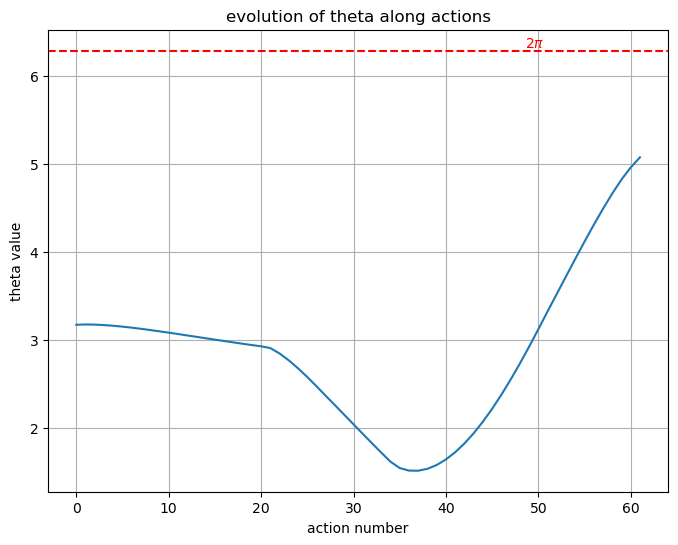

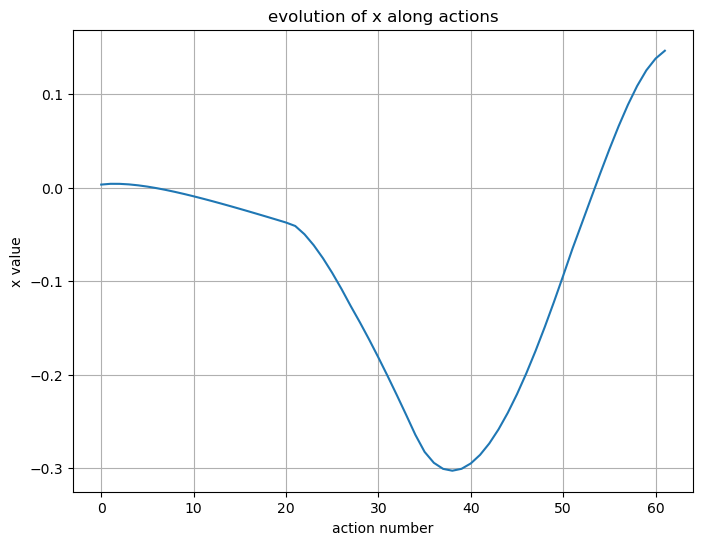

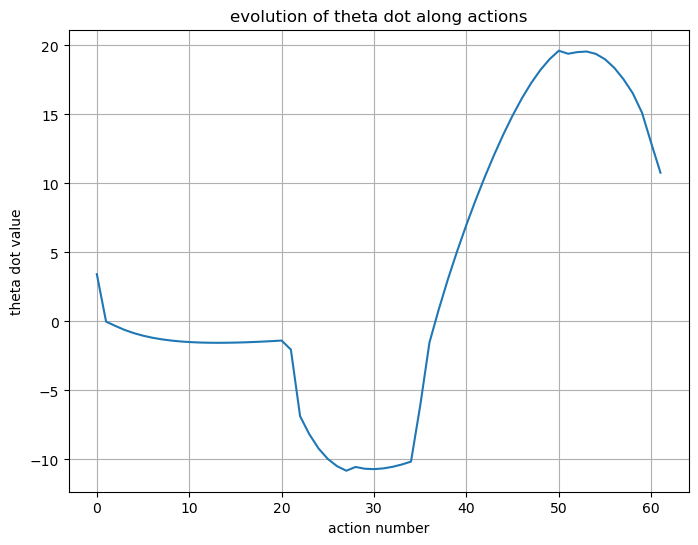

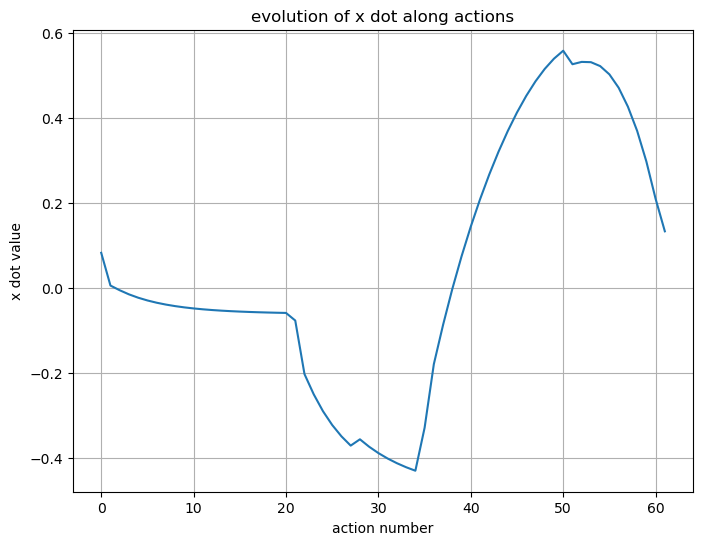

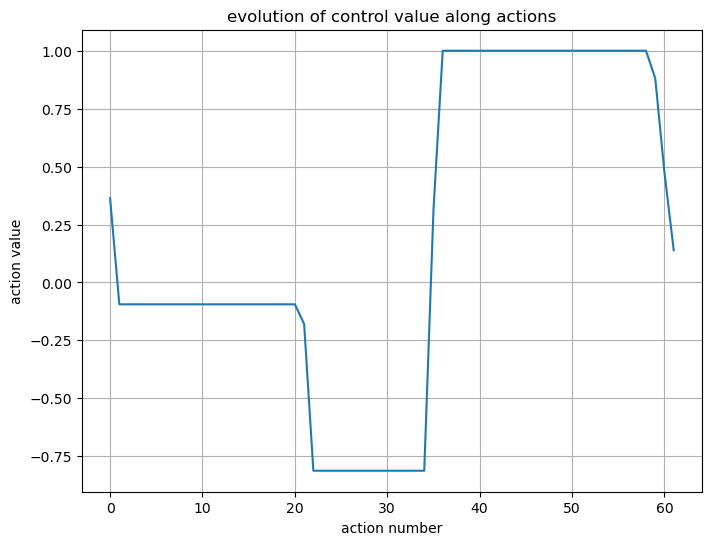

In [89]:
import pyautogui
from pynput.mouse import Listener

# Function to map cursor x position to action
def cursor_to_action(x, screen_width, action_min=-1, action_max=1):
    return-(( x / screen_width) * (action_max - action_min) + action_min)

# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000,swing = True)

# Main loop to continuously track the cursor position and control the robot
screen_width, screen_height = pyautogui.size()  # Get screen dimensions

# Global flag to stop the loop when mouse is clicked
stop_loop = False

x_dem = []
theta_dem = []
xdot_dem = []
thetadot_dem = []
action_dem = []

# Listener function to detect mouse click
def on_click(x, y, button, pressed):
    global stop_loop
    if pressed:  # If the mouse button is pressed
        stop_loop = True  # Set the flag to True
# Start the mouse listener in the background
listener = Listener(on_click=on_click)
listener.start()

while not stop_loop :
    # Get the current cursor position
    cursor_x, cursor_y = pyautogui.position()
    
    # Map the cursor's x position to robot action
    action = cursor_to_action(cursor_x, screen_width)
    
    # Step the environment with the new action
    state, dead, truncated = env.step(action)
    x_dem.append(state[0])
    theta_dem.append(state[2])
    xdot_dem.append(state[1])
    thetadot_dem.append(state[3])
    action_dem.append(action)
    if state[2] > 2* np.pi :
        stop_loop = True
    # Optionally, print or log the state or action if needed
    print(f"Cursor X: {cursor_x}, Action: {action}")
    
    # Add a sleep interval to control the loop speed if needed
    time.sleep(0.05)  # Adjust for responsiveness (lower values = faster control)
# Stop the listener once the loop is stopped
listener.stop()

print("Loop stopped by mouse click.")

#plotting the obtained trajectory
import matplotlib.pyplot as plt



#plot theta
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(theta_dem)),theta_dem)
plt.xlabel('action number')
plt.ylabel('theta value')
plt.title('evolution of theta along actions')
# Add a horizontal line at y = 2 * pi
plt.axhline(y=2 * np.pi, color='r', linestyle='--', label=r'$2\pi$')
plt.text(len(theta_dem) * 0.8, 2 * np.pi, r'$2\pi$', color='r', ha='center', va='bottom')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(x_dem)),x_dem)
plt.xlabel('action number')
plt.ylabel('x value')
plt.title('evolution of x along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot theta dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(thetadot_dem)),thetadot_dem)
plt.xlabel('action number')
plt.ylabel('theta dot value')
plt.title('evolution of theta dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(xdot_dem)),xdot_dem)
plt.xlabel('action number')
plt.ylabel('x dot value')
plt.title('evolution of x dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot actions
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(action_dem)),action_dem)
plt.xlabel('action number')
plt.ylabel('action value')
plt.title('evolution of control value along actions')
# Add grid to the plot
plt.grid(True)
plt.show()


Save the results in txt files

In [ ]:
modify_hist = False #change to True if you want to edit the files (only if taking a new human demo)

In [ ]:
if modify_hist : #to avoid modifying the saved files by accident
    with open('x_dem.txt', 'w') as file:
        for item in x_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('xdot_dem.txt', 'w') as file:
        for item in xdot_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('theta_dem.txt', 'w') as file:
        for item in theta_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('thetadot_dem.txt', 'w') as file:
        for item in thetadot_dem:
            file.write(f"{item}\n")  # Write each item on a new line
    with open('action_dem.txt', 'w') as file:
        for item in action_dem:
            file.write(f"{item}\n")  # Write each item on a new line
    

Load the results from saved demo file

In [ ]:
with open('x_dem.txt', 'r') as file:
    x_dem = [float(line.strip()) for line in file]

with open('theta_dem.txt', 'r') as file:
    theta_dem = [float(line.strip()) for line in file]

with open('action_dem.txt', 'r') as file:
    action_dem = [float(line.strip()) for line in file]

with open('xdot_dem.txt', 'r') as file:
    xdot_dem = [float(line.strip()) for line in file]

with open('thetadot_dem.txt', 'r') as file:
    thetadot_dem = [float(line.strip()) for line in file]



To display the human demonstration run the following cell

In [46]:
env = EnvRealistic(TIME_HORIZON=1000,swing = True)
time.sleep(2)
for t in range(len(action_dem)):
    state, dead, truncated = env.step(action_dem[t])
    
    time.sleep(0.05)


0.2219553438354247  theta DEAD
0.20576198653157807  theta DEAD
-0.23062288757739782  theta DEAD
-0.3283437687429043  theta DEAD
-0.42845932180728774  theta DEAD
-0.5298170117734041  theta DEAD
-0.6314453488715872  theta DEAD
-0.7325227378809563  theta DEAD
-0.8323535848851686  theta DEAD
-0.9281509724961619  theta DEAD
-1.0208987830617176  theta DEAD
-1.1116698456987395  theta DEAD
-1.2001924450608092  theta DEAD
-1.2862466872564735  theta DEAD
-1.3696538898825152  theta DEAD
-1.4502702046087415  theta DEAD
-1.5279811784512447  theta DEAD
-1.6025449883813825  theta DEAD
-1.6411332130696519  theta DEAD
-1.6529910911991554  theta DEAD
-1.6418118606592436  theta DEAD
-1.6056025058850372  theta DEAD
-1.548457202935718  theta DEAD
-1.4720618751318408  theta DEAD
-1.3774909969627718  theta DEAD
-1.2657344195488194  theta DEAD
-1.1377745134007347  theta DEAD
-0.9946579337627515  theta DEAD
-0.8375494915014643  theta DEAD
-0.6677644099739849  theta DEAD
-0.4867781849381426  theta DEAD
-0.30539

In [ ]:
xlistbis = np.array(xpos_list[:131])
thetalistbis= np.array(theta_list[:131])
xdot_list = np.array(xdot_list)
thetadot_list = np.array(thetadot_list)

In [ ]:
state_D = np.vstack((xlistbis,xdot_list,thetalistbis,thetadot_list)).T